## Import libraries

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from lenet5 import LeNet
import matplotlib
import matplotlib.pyplot as plt

## Set Parameters 

In [2]:
# Check if cuda is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model Training Parameters
EPOCHS = 10
LEARNING_RATE = 2e-3
BATCH_SIZE = 32

# Save plots in the folder ./plots or show them
SAVE_PLOTS = False


## Training and Validation functions

In [3]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_target in train_loader:

        # Set gradient to zero
        optimizer.zero_grad()

        # If there is a GPU, pass the data to the GPU

        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction

        # Call model forward()
        y_predict, _ = model(X)

        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

        # Adjusting weights
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def test(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for X, y_target in valid_loader:
        # If there is a GPU

        X = X.to(device)
        y_target = y_target.to(device)

        # Prediction and loss

        # Call model forward()
        y_predict, _ = model(X)
        
        # Get loss
        loss = criterion(y_predict, y_target)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss


def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


In [4]:
def training_loop(model, criterion, optimizer, train_loader, test_loader,
                  epochs, device, print_every=1):

    train_losses = []
    valid_losses = []

    train_accuracies = []
    valid_accuracies = []

    # Train model
    for epoch in range(epochs):
        model, optimizer, train_loss = train(train_loader, model,
                                             criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validation

        # Disable gradient calculation to save memory
        with torch.no_grad():
            model, valid_loss = test(test_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device)
            valid_acc = get_accuracy(model, test_loader, device)

            train_accuracies.append(train_acc)
            valid_accuracies.append(valid_acc)

            print(f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    return model, optimizer, (train_losses, valid_losses), (train_accuracies, valid_accuracies)


## Loaders and Transformations

In [5]:
# Image augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalizing the test images
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Loading CIFAR10 using torchvision.datasets
traindata = datasets.CIFAR10('./data', train=True, download=False,
                             transform=transform_train)

# Creating a pytorch loader for a Deep Learning model
train_loader = torch.utils.data.DataLoader(
    traindata, batch_size=BATCH_SIZE, shuffle=True)

# Loading the test images and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data', train=False,
                                                           transform=transforms.Compose([transforms.ToTensor(),
                                                                                         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
                                                           ), batch_size=BATCH_SIZE, shuffle=True)


## Model Selection

In [6]:
model = LeNet().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


## Train

In [7]:
model, optimizer, (train_losses, valid_losses), (train_accuracies, valid_accuracies) = training_loop(model, criterion, optimizer,
                                                                                                     train_loader, test_loader, EPOCHS, DEVICE)


Epoch: 0	Train loss: 2.2141	Valid loss: 2.0404	Train accuracy: 25.13	Valid accuracy: 26.68
Epoch: 1	Train loss: 1.9590	Valid loss: 1.8316	Train accuracy: 31.37	Valid accuracy: 33.97
Epoch: 2	Train loss: 1.8135	Valid loss: 1.6848	Train accuracy: 35.74	Valid accuracy: 38.04
Epoch: 3	Train loss: 1.6995	Valid loss: 1.5742	Train accuracy: 39.41	Valid accuracy: 41.84
Epoch: 4	Train loss: 1.6213	Valid loss: 1.5287	Train accuracy: 40.92	Valid accuracy: 43.79
Epoch: 5	Train loss: 1.5665	Valid loss: 1.4602	Train accuracy: 44.39	Valid accuracy: 47.82
Epoch: 6	Train loss: 1.5244	Valid loss: 1.4533	Train accuracy: 42.33	Valid accuracy: 46.52
Epoch: 7	Train loss: 1.4797	Valid loss: 1.3881	Train accuracy: 47.54	Valid accuracy: 50.21
Epoch: 8	Train loss: 1.4352	Valid loss: 1.3131	Train accuracy: 50.02	Valid accuracy: 53.11
Epoch: 9	Train loss: 1.3928	Valid loss: 1.3000	Train accuracy: 50.88	Valid accuracy: 53.21


## Plot Accuracy and Loss

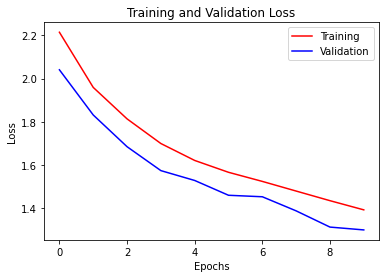

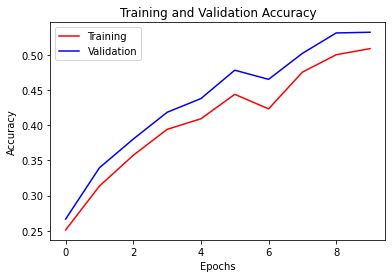

In [8]:

if SAVE_PLOTS:
    matplotlib.use("Agg")

# Plot Loss
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, color="r", label="Training")
plt.plot(range(len(valid_losses)), valid_losses, color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Loss")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig(
        "plots/centralised_LR[{}]_EPOCHS[{}]_loss.png".format(LEARNING_RATE, EPOCHS))
else:
    plt.show()

# Plot Accuracy
plt.figure()
plt.title("Training and Validation Accuracy")
plt.plot(range(len(train_accuracies)),
         train_accuracies, color="r", label="Training")
plt.plot(range(len(valid_accuracies)), valid_accuracies,
         color="b", label="Validation")
plt.legend(loc="best")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
if SAVE_PLOTS:
    plt.savefig(
        "plots/centralised_LR[{}]_EPOCHS[{}]_accuracy.png".format(LEARNING_RATE, EPOCHS))
else:
    plt.show()
